In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from fbm import FBM
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm
from scipy.optimize import root_scalar

from importlib import reload
import realized_volatility
reload(realized_volatility)

import stochastic_volatility
reload(stochastic_volatility)

import hurst_estimation
reload(hurst_estimation)

from stochastic_volatility import price_from_volatility
from realized_volatility import realized_volatility
from simulation import *
from hurst_estimation import m_estimator, w_estimator, adopted_whittle_estimator

### Process + white noise

Microstructure noise for gBM instantaneous volatility.

In [39]:
df = pd.read_csv('../data/oxfordmanrealizedvolatilityindices.csv')
df = df.loc[df.Symbol == '.SPX'].reset_index(drop=True)

vol_proc = np.array(np.sqrt(df.rv5 / 252)) # normalize to daily vol

In [40]:
n_est = 78
n_days = 5000
n_sample = n_days * n_est + 1

sigma = 0.02

# gBM sampling
gBM = simulate_gBM(n_sample, is_mart=True, sigma=sigma, init=np.exp(-7.2), T=n_days)
X = price_from_volatility(gBM, T=n_days)
rv = realized_volatility(X, n_est=n_est, T=n_days)

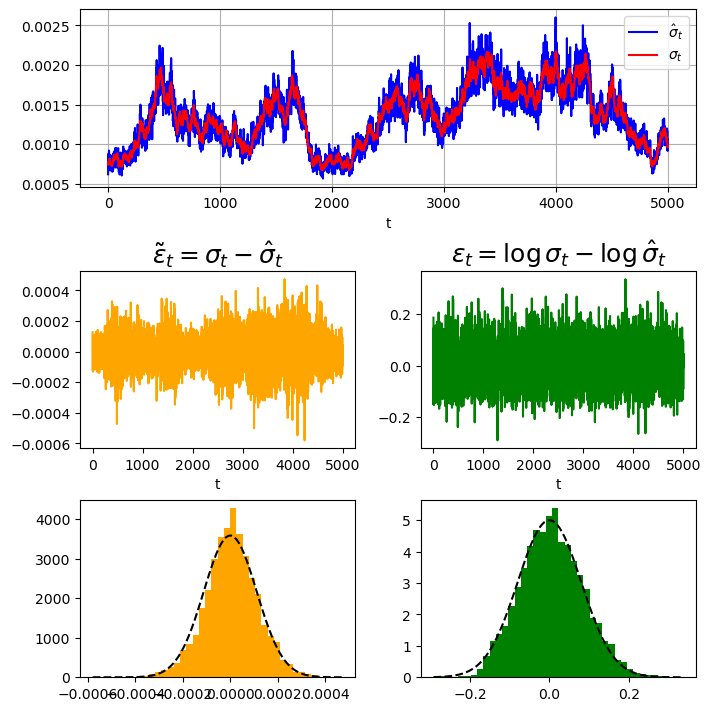

In [41]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
spec = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(spec[0, :])

ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])

ax20 = fig.add_subplot(spec[2, 0])
ax21 = fig.add_subplot(spec[2, 1])

ax0.plot(rv, 'b', label=r'$\hat\sigma_t$')
ax0.plot(gBM[n_est-1::n_est], 'r', label=r'$\sigma_t$')
ax0.grid('on')
ax0.set_xlabel('t')
ax0.legend()

ax10.plot(gBM[n_est-1::n_est] - rv, 'orange')
ax10.set_title(r'$\tilde\varepsilon_t = \sigma_t - \hat\sigma_t$', fontsize=18)
ax10.set_xlabel('t')
ax11.plot(np.log(gBM[n_est-1::n_est]) - np.log(rv), 'g')
ax11.set_title(r'$\varepsilon_t = \log\sigma_t - \log\hat\sigma_t$', fontsize=18)
ax11.set_xlabel('t')

ax20.hist(gBM[n_est-1::n_est] - rv, bins=40, color='orange', density=True)
ax21.hist(np.log(gBM[n_est-1::n_est]) - np.log(rv), bins=40, color='g', density=True)

e1 = gBM[n_est-1::n_est] - rv
e2 = np.log(gBM[n_est-1::n_est]) - np.log(rv)

x1 = np.linspace(np.min(e1), np.max(e1), 100)
x2 = np.linspace(np.min(e2), np.max(e2), 100)

ax20.plot(x1, norm.pdf(x1 / e1.std()) / e1.std(), 'k--')
ax21.plot(x2, norm.pdf(x2 / e2.std()) / e2.std(), 'k--')


plt.show()

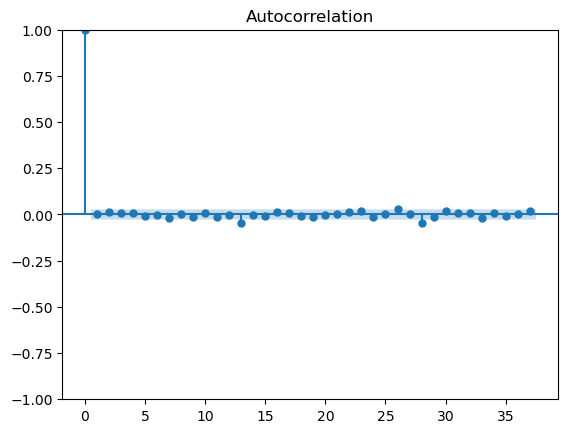

In [47]:
plot_acf(np.log(gBM[n_est-1::n_est]) - np.log(rv))
plt.show()

0.14348028756139383

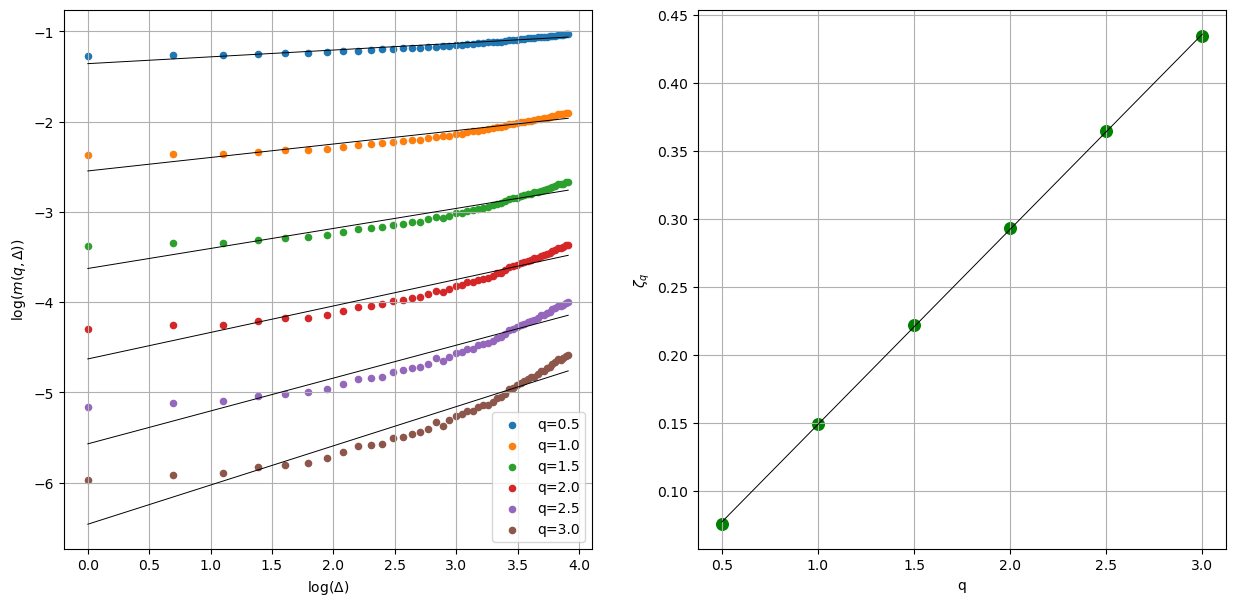

In [16]:
m_estimator(np.log(rv), is_plotting=True, intersect=True)

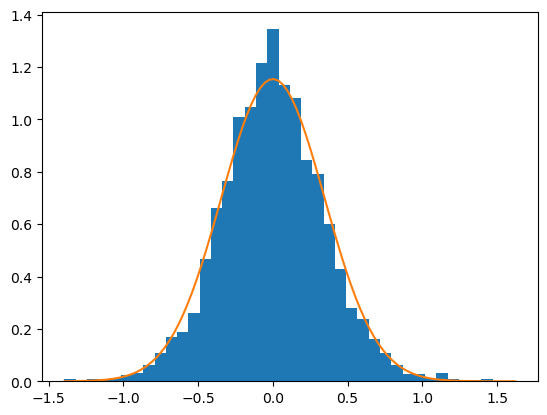

In [18]:
fig, ax = plt.subplots()

ax.hist(np.diff(np.log(vol_proc)), density=True, bins=40)
e = np.diff(np.log(vol_proc))
x1 = np.linspace(np.min(e), np.max(e), 100)

ax.plot(x1, norm.pdf(x1 / e.std()) / e.std())

plt.show()

In [21]:
# OUOU sampling
OUOU, Y = simulate_OUOU(n_sample=n_sample,
                        sigma_x=0.3,
                        sigma_y=0.05*4,
                        lam=0.3,
                        beta=0.005*16,
                        T=n_days,
                        mu=-7.2,
                        init=-7.2)

X_ouou = price_from_volatility(np.exp(OUOU), T=n_days)
rv_ouou = realized_volatility(X_ouou, n_est=n_est, T=n_days)

In [22]:
# fBM sampling
n_days=5000
H = 0.1
n_est = 78
sig = 1.25 / n_days**H
fBM = sig*FBM(n_days*n_est, hurst=H, length=n_days).fbm() - 7.2 # 0.3
 
X_fbm = price_from_volatility(np.exp(fBM), T=n_days)
rv_fbm = realized_volatility(X_fbm, n_est=n_est, T=n_days)

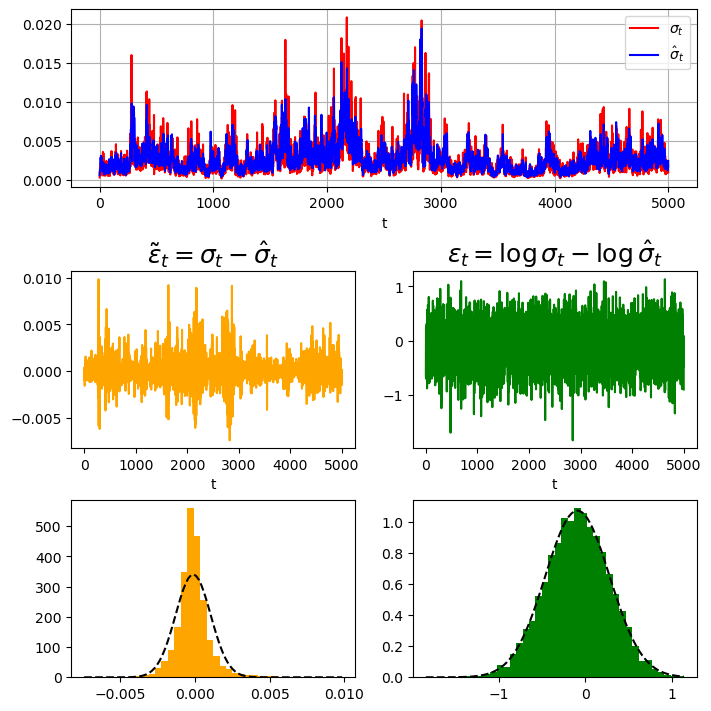

In [34]:
fig = plt.figure(figsize=(7, 7), constrained_layout=True)
spec = fig.add_gridspec(3, 2)

ax0 = fig.add_subplot(spec[0, :])

ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])

ax20 = fig.add_subplot(spec[2, 0])
ax21 = fig.add_subplot(spec[2, 1])

ax0.plot(np.exp(fBM[n_est-1::n_est]), 'r', label=r'$\sigma_t$')
ax0.plot(rv_fbm, 'b', label=r'$\hat\sigma_t$')
ax0.grid('on')
ax0.set_xlabel('t')
ax0.legend()

ax10.plot(np.exp(fBM[n_est-1::n_est]) - rv_fbm, 'orange')
ax10.set_title(r'$\tilde\varepsilon_t = \sigma_t - \hat\sigma_t$', fontsize=18)
ax10.set_xlabel('t')
ax11.plot(fBM[n_est-1::n_est] - np.log(rv_fbm), 'g')
ax11.set_title(r'$\varepsilon_t = \log\sigma_t - \log\hat\sigma_t$', fontsize=18)
ax11.set_xlabel('t')

ax20.hist(np.exp(fBM[n_est-1::n_est]) - rv_fbm, bins=40, color='orange', density=True)
ax21.hist(fBM[n_est-1::n_est] - np.log(rv_fbm), bins=40, color='g', density=True)

e1 = np.exp(fBM[n_est-1::n_est]) - rv_fbm
e2 = fBM[n_est-1::n_est] - np.log(rv_fbm)

x1 = np.linspace(np.min(e1), np.max(e1), 100)
x2 = np.linspace(np.min(e2), np.max(e2), 100)

ax20.plot(x1, norm.pdf((x1 - np.mean(e1)) / e1.std()) / e1.std(), 'k--')
ax21.plot(x2, norm.pdf((x2 - np.mean(e2)) / e2.std()) / e2.std(), 'k--')


plt.show()

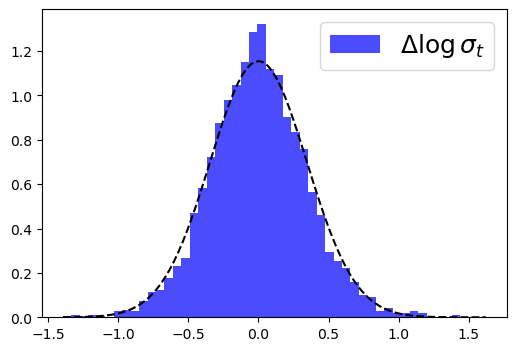

In [26]:
fig, ax = plt.subplots(figsize=(6, 4))

y = np.diff(np.log(vol_proc))
x = np.linspace(np.min(y), np.max(y), 100)

ax.hist(y, density=True, bins=50, alpha=0.7, color='b', label=r'$\Delta\log\sigma_t$')
ax.legend(fontsize=18)
ax.plot(x, norm.pdf((x - np.mean(y)) / y.std()) / y.std(), 'k--')

In [28]:
m_estimator(np.log(vol_proc)), np.var(np.diff(np.log(vol_proc)))

(0.14148280936590168, 0.11939415610126068)

#### Looks like a white noise?

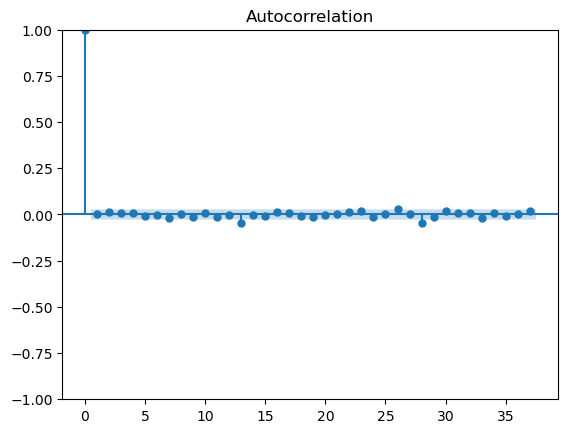

In [53]:
plot_acf(np.log(gBM[n_est-1::n_est]) - np.log(rv))
plt.show()

#### The noise is correlated with the increments of volatility itself!

In [50]:
np.corrcoef(np.array([
            (np.log(rv_fbm) - fBM[n_est-1::n_est])[1:], 
            (np.log(rv_fbm) - fBM[n_est-1::n_est])[:-1], 
            np.diff(fBM[n_est-1::n_est])
]))

array([[ 1.        , -0.07095949, -0.70887136],
       [-0.07095949,  1.        ,  0.53765769],
       [-0.70887136,  0.53765769,  1.        ]])

In [51]:
fig = make_subplots(rows=4, cols=1)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=np.log(vol_proc), name='log(Realized vol), daily'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=np.log(rv_ouou), name='Simulated OUOU, daily'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=np.log(rv_fbm), name='Simulated fBM, daily'),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=df['Unnamed: 0'], y=np.log(rv), name='Simulated gBM, daily'),
    row=4, col=1
)


fig.update_layout(height=800, width=800, title_text="Realized volatility: market data & simulation")
fig.show()